In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import xarray as xr
import re
import matplotlib.pyplot as plt

In [3]:
workdir = '/Users/diana/Dropbox/UW/Research/rasm'
calm_metadata = 'CALM_Summary_table_latslons.csv'

# read in data
calm = pd.read_csv(os.path.join(workdir, 'calm', calm_metadata), 
                   delimiter=',',
                   header=0,
                   error_bad_lines=False,
                   nrows=236,
                   encoding='ISO-8859-1')

# rename columns 
calm.rename(index=str, columns={"LAT": "lat", "LONG": "lng"}, inplace=True)

those string parsing functions don't work for the heterogeneity of this data, write my own, with help from this site: http://en.proft.me/2015/09/20/converting-latitude-and-longitude-decimal-values-p/)

In [4]:
def parse_calm_lat_or_lon(x):
    '''takes in lat or lon from CALM data and produces list of degree, minutes, seconds
    or decimal. If element is a decimal, returns decimal as a float. If not decimal, 
    or decimal with direction, it returns a decimal without the direction as a float'''
    # symbols to parse by
    upside_down_exc = '¡'
    degree_sign= u'\N{DEGREE SIGN}'
    single_quote = "'"
    double_quote = '''"'''
    space = " "
    comma = ","
    v = 'v'
    zero_aigu = calm['lat'][70][8]
    # combine all symbols into one reg ex
    split_on = '%s|\s|%s|%s|%s|%s|%s|%s|%s|' % (upside_down_exc, degree_sign, single_quote, 
                                             double_quote, space, comma, v, zero_aigu)
    # parse lat or lon with reg ex 
    splitt = re.split(split_on, x)

    # remove comma and v characters from strings in parsed list 
    chars_to_remove = [',' 'v']
    for char_to_remove in chars_to_remove:
        if char_to_remove in splitt: 
            splitt.remove(char_to_remove)
            
    # remove empty strings from parsed list 
    parsed_list = list(filter(None, splitt))

    # 4 cases 
    if len(parsed_list) == 1:
        # decimal so leave as is but convert to float
        return(float(parsed_list[0]))
    elif len(parsed_list) == 2: 
        # decimal with direction, remove direction, return first element as float
        # with the correct sign 
        direction = parsed_list[1]
        if direction == "S" or direction == "W": 
            return(float(parsed_list[0]) *-1)
        else: 
            return(float(parsed_list[0]))
    else:
        # degree, min, sec OR min, sec; convert to decimal. 
        if len(parsed_list) == 3:
            # case with no minutes
            dd = float(parsed_list[0]) + float(parsed_list[1])/60.0
            direction = parsed_list[2]
        elif len(parsed_list) == 4:
            # case where minutes are included
            '''print(parsed_list[2])
            print(type(parsed_list[2][2][0]))'''
            dd = (float(parsed_list[0]) + float(parsed_list[1])/60.0 
                  + float(parsed_list[2])/(60.0*60.0))
            direction = parsed_list[3]
        if direction == "S" or direction == "W":
            dd *= -1
        return(dd)

convert lats/lons from degree minute second to decimal format

In [5]:
calm['lat_dec'] = calm['lat'].apply(parse_calm_lat_or_lon)
calm['lng_dec'] = calm['lng'].apply(parse_calm_lat_or_lon)

//anaconda/envs/vic_test_env/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


convert longitude from -180 to 180 to 0 to 360

In [6]:
def convert_longitude_0_360(longitude):
    ''' takes in longitude between -180 to 180 and converts it to the 0 to 360 longitude'''
    lng = np.mod(longitude, 360)
    return lng 

In [7]:
# add column to DataFrame with longitudes from 0 to 360
calm['lng_dec_360'] = calm['lng_dec'].apply(convert_longitude_0_360)

figure out which RASM domain grid cell the lats/lons are in

In [8]:
# load domain file 
domain_file = xr.open_dataset(os.path.join('/Users/diana/Dropbox/UW/Research/rasm',
                                          'domain.lnd.wr50a_ar9v4.130607.nc'))
u = calm['lat_dec'][0]
z = calm['lng_dec'][0]
zz = calm['lng_dec_360'][0]

# make a copy to mask out all grid cells and fill in the ones I want to run
domain_file_masked = xr.open_dataset(os.path.join('/Users/diana/Dropbox/UW/Research/rasm',
                                          'domain.lnd.wr50a_ar9v4.130607.nc'))

In [9]:
def find_xc_yc_domain_file(lat_dec, lng_dec, domain_file):
    '''takes in lat, lng (in 0-360 format), and domain file (as xarray dataset) for a 
    CALM observation site and finds xc and yc coordinates of the grid cell in the domain file 
    that the observation site is in'''
    min_yc = np.abs(domain_file.yc.values[0,0] - lat_dec)
    min_xc = np.abs(domain_file.xc.values[0,0] - lng_dec)
    ni_ind = 0
    nj_ind = 0

    for i in range(0, domain_file.ni.values.max()):
        for j in range(0, domain_file.nj.values.max()):
            if (np.abs(domain_file.yc.values[j,i] - lat_dec) <= min_yc) and \
                (np.abs(domain_file.xc.values[j,i] - lng_dec) <= min_xc):
                min_yc = np.abs(domain_file.yc.values[j,i] - u)
                min_xc = np.abs(domain_file.xc.values[j,i] - zz)
                ni_ind = i
                nj_ind = j

    njj_ind = np.argmin(np.abs(domain_file.yc.values[:,ni_ind] - lat_dec))

    return (domain_file.yc.values[njj_ind, ni_ind], domain_file.xc.values[nj_ind, ni_ind])

In [10]:
def make_domainfile_gridcell_active(latt, lngg, atol):
    gridcell_flag = None
    for nj in range(0, domain_file_masked.mask.nj.values[-1]):
        for ni in range(0, domain_file_masked.mask.ni.values[-1]):
            if (np.isclose(domain_file_masked.mask[nj, ni].xc, lngg, atol=atol)) and (np.isclose(domain_file_masked.mask[nj, ni].yc, latt, atol=atol)):
                # gridcell_flag is a flag to determine whether there is a domain file gridcell for 
                # the observation site in question
                gridcell_flag = True
                # assign gridcell indices
                nj_ind = nj
                ni_ind = ni
            
    if gridcell_flag:
        return (nj_ind, ni_ind, gridcell_flag)
    else: 
        # assign junk values
        nj_ind = 0
        ni_ind = 0
        print("this pair didn't have a home: latt is %f, lngg is %f" % (latt, lngg))
        return (nj_ind, ni_ind, gridcell_flag)

mask out all of the gridcells in the domain file and make a copy of that new dataset

In [11]:
# mask out all grid cells
domain_file_masked.mask[:,:] = 0

find grid cell that observation site is in and make mask value for that gridcell equal to 1 in domain_file_masked

In [12]:
# loop over grid cells and make them all active in the domain file mask 
count = 0
for ind in range(0, len(calm['lat_dec'])):

    # find minimum distance between observation site and all gridcells 
    min_arg = (((domain_file_masked.xc - calm['lng_dec_360'][ind])**2) + 
               ((domain_file_masked.yc - calm['lat_dec'][ind])**2)).argmin()
    
    # get index of that grid cell so that it can be ran
    nj_ind, ni_ind = np.unravel_index(min_arg, domain_file_masked.xc.shape)           
    
    domain_file_masked.mask[nj_ind, ni_ind] = 1
    
    count += 1

In [13]:
domain_file_masked.to_netcdf('calm_domain_file.nc')

In [14]:
u = xr.open_dataset('calm_domain_file.nc')
u.mask.sum()

<xarray.DataArray 'mask' ()>
array(149)

In [15]:
params = xr.open_dataset('vic_params_wr50a_vic5.0.dev_20160328.nc')
params['run_cell'] = params.run_cell.where(domain_file_masked.mask == 1)
params.to_netcdf('params_calm_sites_11282016.nc')
u['mask'].values[:,:] = 0
u['mask'].values[params.run_cell.values == 1] = 1
u['mask'].values = u['mask'].values.astype(np.int32)
u.to_netcdf('calm_domain_file_adj_11282016.nc')

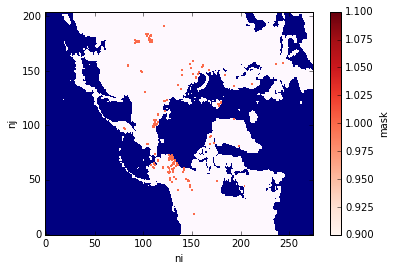

In [16]:
dpi = 50
domain_file.mask.plot(cmap=plt.cm.gist_ncar, add_colorbar=False)
domain_file_masked.mask.where(domain_file_masked.mask.values == 1).plot(cmap=plt.cm.Reds)

plotname = 'calm_obs_site_coverage.png'
savepath = os.path.join(workdir, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

In [20]:
calm['lng_dec_360'][5]

211.53333333333333